In [34]:
import requests
import os
import torch
import torchvision.models as models
from torchvision import transforms
import clip
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
search_url = "https://collectionapi.metmuseum.org/public/collection/v1/search"
params = {
    "q": "Vincent van Gogh",
    "artistOrCulture": True,
}
response = requests.get(search_url, params=params)
data = response.json()

In [10]:
object_ids = data.get("objectIDs", [])
print(f"Found {len(object_ids)} artworks by Van Gogh.")

save_dir = "van_gogh_images"
os.makedirs(save_dir, exist_ok=True)


Found 302 artworks by Van Gogh.


In [17]:
downloaded = 0
for object_id in object_ids:
    if downloaded >= 25:
        break
    
    object_url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{object_id}"
    object_response = requests.get(object_url)
    object_data = object_response.json()

    image_url = object_data.get("primaryImage")
    title = object_data.get("title", f"van_gogh_{object_id}")

    if image_url:
        print(f"Downloading {title}...")
        img_response = requests.get(image_url)
        img_path = os.path.join(save_dir, f"{title.replace(' ', '_').replace(':', '')}.jpg")
        #print(img_path)

        with open(img_path, "wb") as f:
            f.write(img_response.content)

        downloaded += 1

print("Done!")

Done!


In [2]:
resnet = models.resnet50(pretrained=True)
model = resnet.eval()
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])
transform = transforms.ToTensor()

img = Image.open("van_gogh_images/irises.jpg")
img_tensor = transform(img).unsqueeze(0)


with torch.no_grad():
    features = feature_extractor(img_tensor)

print(features)


C:\Users\Kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[[[0.1418]],

         [[0.2107]],

         [[0.2022]],

         ...,

         [[0.2474]],

         [[0.4633]],

         [[0.5845]]]])


In [32]:
model, preprocess = clip.load("ViT-B/32", device=device)
feature_vectors = []
all_files = os.listdir("van_gogh_images")
for path in all_files[1:]:
    img = Image.open(f"van_gogh_images/{path}")        
    image = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    feature_vectors.append(image_features[0].cpu())



In [39]:
img1 = Image.open("van_gogh_images/Cypresses.jpg")
img2 = Image.open("van_gogh_images/Cypresses-protected-intensity-DEFAULT-V2.jpg")
image_1 = preprocess(img1).unsqueeze(0).to(device)
image_2 = preprocess(img2).unsqueeze(0).to(device)
with torch.no_grad():
    features1 = model.encode_image(image_1)
    features2 = model.encode_image(image_2)
print(features1[0][0:20])
print(features2[0][0:20])

tensor([ 0.7695, -0.2408,  0.0120, -0.0094, -0.1647,  0.0388,  0.0175,  0.1913,
        -0.1545,  0.5303, -0.4307,  0.1516, -0.0612, -0.1912,  0.3921,  0.0323,
        -0.0354,  0.0248,  0.0152, -0.4158], device='cuda:0',
       dtype=torch.float16)
tensor([ 0.7793, -0.2512,  0.0078, -0.0121, -0.1587,  0.0314,  0.0099,  0.2220,
        -0.1559,  0.5234, -0.4263,  0.1676, -0.0603, -0.1940,  0.3833,  0.0256,
        -0.0468,  0.0385,  0.0122, -0.4028], device='cuda:0',
       dtype=torch.float16)


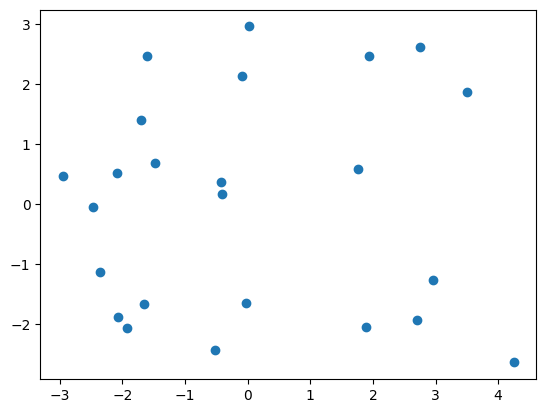

In [35]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(feature_vectors)
plt.figure()
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.show()